# PC 5 : Méthodes itératives pour la résolution de systèmes linéaires

**<big> Préparation avant la PC :</big>**

**Les questions 1 et 2 de l'exercice 1 et 1 à 3 de l'exercice 2 sont à préparer** avant la séance de PC du 28/09.

**<big><font color=black><span style="background-color:deepskyblue">Bonus</span></font> après la PC :</big>** 
**Les exercices 2, 3 et 4 contiennent des parties <font color=black><span style="background-color:deepskyblue"> </span></font> à rendre (en option) avant le 02/10 à 20h00.**

In [1]:
# Ce package permet de travailler efficacement avec des tableaux
import numpy as np
# Ce package propose de fonctions d'aglebre lineaire (inverse, determinant...)
import numpy.linalg as lin
from scipy.linalg import solve_banded
# Ce package permet de travailler avec des matrices creuses
import scipy.sparse as sparse
# Cette fonction calcule les valeurs propres d'une matrice stockée creuse
from scipy.sparse.linalg import eigsh as sparse_eigs

# Ce package permet de faire des sorties graphiques
from matplotlib import pyplot as plt

>**Rappels et notations :**
>
>- Étant donnée une norme $\left\Vert \cdot \right\Vert$ sur $\mathbb K^n$ ($\mathbb K = \mathbb R$ ou $\mathbb C$), on définit la norme subordonnée associée sur $M_n(\mathbb{K})$ par
>
>$$\left\Vert A \right\Vert = \sup_{\substack{x\in\mathbb{K}^n \\ x\neq 0}} \frac{\left\Vert Ax \right\Vert}{\left\Vert x \right\Vert} = \max_{\substack{x\in\mathbb{K}^n \\ \left\Vert x \right\Vert= 1}}\left\Vert Ax \right\Vert.$$
>
>- Une norme $\left\Vert \cdot \right\Vert$ sur $M_n(\mathbb K)$ est dite matricielle (ou d'algèbre) si 
>
>$$\forall A,B \in M_n(\mathbb K),\quad{} \left\Vert AB\right\Vert \leq \left\Vert A\right\Vert \left\Vert B\right\Vert.$$
>
>- Les normes subordonnées sont des normes matricielles. Il existe des normes matricielles qui ne sont pas des normes subordonnées, par exemple la norme de Frobenius : $\left\Vert A\right\Vert_F = \sqrt{\mathrm{tr}(A^{*}A)}$.
>
>- Pour tout matrice $A\in M_n(\mathbb{K})$ inversible, on définit son conditionnement, associé à une norme subordonnée $\left\Vert \cdot \right\Vert$, par
>
>$$\kappa(A) = \Vert A \Vert \Vert A^{-1} \Vert.$$
>
>- Soit $A\in M_n(\mathbb{K})$, on appelle rayon spectral de $A$ la quantité
>
>$$\rho(A)=\max\limits_{\lambda\in \text{Sp(A)}} \vert\lambda\vert.$$
>
>- Si $A$ est une matrice normale ($A^*A = AA^*$), $\left\Vert A \right\Vert_2 = \rho(A)$.

> **Remarque sur la performance avant de commencer :** Dans cette PC, nous allons étudier des méthodes itératives et leur convergence. Dans la pratique, ces méthodes sont surtout intéressantes lorsqu'on a affaire à des matrices creuses, parce qu'elles permettent de tirer pleinement profit de cette caractéristique. Dans les parties "implémentation", nous insisterons sur la strucutre creuse et sur les performances des algorithmes dans certaines questions, ce sera alors indiqué de manière explicite. Cependant, dans les autres questions on pourra restreindre la performance des codes pour des raisons pédagogiques (notamment en stockant toutes les itérations de l'algorithme, ou sans exploiter la structure des matrices pour simplifier le code). 

## Exercice 1 : Autour du rayon spectral

Dans tout l'exercice, on considère $A\in M_n(\mathbb{C})$.

### Question 1 

Montrer que pour toute norme subordonnée, $\rho(A)\leq \left\Vert A \right\Vert$. Montrer que cette propriété reste vraie pour une norme matricielle quelconque. 

<blockquote style="border: 2px solid #666; padding: 10px; background-color: #ccc;">Pour le cas d'une norme matricielle quelconque, on pourra considérer une matrice de rang 1 construite à l'aide d'un vecteur propre de $A$.</blockquote>

<div class="alert alert-block alert-info">
    Soit $v \in \mathbb{C}_n^*$ tel que $\|v\| = 1$ et $Av = \lambda v$ où $|\lambda| = \rho(A)$. On a
    $$ |\lambda| \|v\| = \| Av \| \leq \|A\| \|v\| \implies \rho(A) \leq \|A\|.$$
    Alors, soit $\| \cdot \|$ une norme matricielle quelconque. Soit $w \in \mathbb{C}_n^*$ et $B = vw \in M_n(\mathbb{C})$. On a
    $$ AB = \lambda B \implies \|\lambda B\| = |\lambda| \|B\| = \|AB\| \leq \|A\| \|B\| $$
    $\implies \rho(A) \leq \|A\|$.
</div>

### Question 2 

Montrer que pour tout $\varepsilon>0$ et toute matrice $A\in M_n(\mathbb{C})$, il existe une norme subordonnée telle que $\left\Vert A \right\Vert \leq \rho(A)+\varepsilon$. 

<blockquote style="border: 2px solid #666; padding: 10px; background-color: #ccc;">On pourra trigonaliser $A$ dans une base bien choisie.</blockquote>

<div class="alert alert-block alert-info">
    Soit $Q$ inversible tel que $Q^{-1}AQ = T$ soit triangulaire supérieure et $T_{i,i} = \lambda_i \forall i$. $\\$
    Soit $0 < \delta << 1$, posons $D_\delta$ une matrice diagonal tel que $D_{i,i} = \delta^i$.
    Alors $(D_\delta)^{-1} T D_\delta = \begin{pmatrix}
\lambda_1 & \delta T_{1,2} & \delta^2 T_{1,3} & \cdots & \delta^{n-1} T_{1,n} \\
0 & \lambda_2 & \delta T_{2,3} & \cdots & \delta^{n-2} T_{2,n} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & ... & \lambda_n
\end{pmatrix} = T_\delta$. $\\$
    Donc $\forall \epsilon > 0, \exists \delta > 0$ tel que 
    $$ \|T_\delta\|_{\infty} \leq \max_{i} |\lambda_i| + \epsilon = \rho(A) + \epsilon.$$
    Alors, montrons que $\|T_\delta\|_{\infty}$ est une norme subordonée de $A$.
    $$ \begin{align}
    \|T_\delta\|_{\infty} &= \max_{x \not= 0} \frac{\|T_\delta x \|_{\infty}}{\|x\|_{\infty}} \\
    &= \max_{x \not= 0} \frac{\| (QD_\delta)^{-1} A (QD_\delta) x \|_{\infty}}{\|x\|_{\infty}} \\
    &= \max_{y \not= 0} \frac{\| (QD_\delta)^{-1} A y \|_{\infty}}{\|(QD_\delta)^{-1} y\|_{\infty}} \\
    &= \max_{y \not= 0} \frac{N(Ay)}{N(y)} \quad \text{où $N(u) = \|(QD_\delta)^{-1}u \|_\infty$ est une norme sur $\mathbb{R}^n$}\\
    &= \|A\|_N
    \end{align}$$
</div>

### Question 3 

Montrer que les conditions suivantes sont équivalentes :

$1$. $\lim\limits_{n\rightarrow \infty} A^n=0$,

$2$. $\forall x\in \mathbb{C}^n,\ \lim\limits_{n\rightarrow \infty} A^nx=0$,

$3$. $\rho(A)<1$,

$4$. Il existe une norme subordonnée telle que $\left\Vert A \right\Vert<1$.

*On pourra montrer que $1. \Rightarrow 2. \Rightarrow 3. \Rightarrow 4. \Rightarrow 1.$*

<div class="alert alert-block alert-info">
    <h3> $1. \implies 2.$ </h3>
    Si $A^n \to 0 \implies \|A^n\| \to 0 \forall \|\cdot\|$.
    Pour $\|\cdot\|$ une norme subordonée, on a $\|A^n x\| \leq \|A^n\| \|x\| \to 0 \quad \forall x$.
    <h3> $2. \implies 3.$ </h3>
    Soit $v \in \mathbb{R}_n^*$ tel que $Av = \lambda v$ où $|\lambda| = \rho(A)$. Alors,
    $$A^n v \to 0 \implies \lambda^n v \to 0 \implies |\lambda| = \rho(A) < 1.$$
    <h3> $3. \implies 4.$ </h3>
    Si $\rho(A) < 1$, alors $\exists \|\cdot\|$ subordonée tel que $\|A\| < 1$ par la question 2.
    <h3> $4. \implies 1.$ </h3>
    Si $\|A\| < 1$, alors $\|A^n\| \leq \|A\|^n \to 0$.
</div>

### Question 4 

Soit $B\in M_n(\mathbb{K})$ telle que $I-B$ est inversible, et $c\in \mathbb{K}^n$. On considère une méthode itérative de la forme

$$ \left\{ \begin{aligned} &x_0 \in \mathbb{K}^n\\ &x_{k+1} = Bx_k + c \quad \forall~k\in\mathbb{N}. \end{aligned}\right. $$

Montrer que la suite $\left(x_k\right)$ converge pour tout $x_0\in\mathbb{K}$ si et seulement si $\rho(B)<1$. Dans le cas où $B$ est une matrice normale, montrer que l'erreur en norme $\left\Vert \cdot \right\Vert_2$ est majorée par une suite géométrique de rayon $\rho(B)$. Que peut-on dire de l'erreur dans le cas d'une matrice quelconque ? *On pourra utiliser la question 2.*

<div class="alert alert-block alert-info">
    Supposons que la suite $(x_k)$ converge. $\\$
    Si $x_k \to x^*$, alors $x^* = Bx^* + c \implies x^* = (I - B)^{-1}c \implies x^*$ est unique. $\\$
    Soit $e_k = x_k - x^*$, on a $e_{k+1} = Be_k \implies e_k = B^k e_0$. $\\$
    Donc $(x_k)$ converge $\forall x_0 \iff e_k \to 0 \quad \forall e_0 \iff \rho(B) < 1$. $\\$
    Alors, $\forall \|\cdot\|$ subordonée on a $\|e_k\| \leq \|B\|^k \|e_0\|$. Si B est normale $\implies \rho(B) = \|B\|_2$. Donc $$ \|e_k\| \leq (\rho(B))^k \|e_0\|_2$$ une suite géométrique de rayon $\rho(B)$.
</div>

### Question 5 

Montrer que pour toute norme matricielle, $\rho(A)=\lim\limits_{n\rightarrow \infty} \left\Vert A^n \right\Vert^{\frac{1}{n}}$. 

<blockquote style="border: 2px solid #666; padding: 10px; background-color: #ccc;">On pourra considérer la matrice $\frac{1}{\rho(A)+\varepsilon}A$.</blockquote>

<div class="alert alert-block alert-info">
    On a $\rho(A)^n = \rho(A^n) < \|A^n\| \implies \rho(A) \leq \|A^n\|^{\frac{1}{n}}$. $\\$
    Alors $\forall \epsilon > 0, \rho\left(\frac{1}{\rho(A) + \epsilon}A\right) = \frac{1}{\rho(A) + \epsilon} \rho(A) < 1 \implies \left(\frac{1}{\rho(A) + \epsilon}A\right)^n \to 0$.
    Donc $\exists n_0$ tel que $\forall n \geq n_0$, 
    $$\begin{align}
    &\left\|\frac{1}{\rho(A) + \epsilon}A\right\|^n < 1 \\
    \iff &\|A^n\| < (\rho(A) + \epsilon)^n\\
    \iff &\|A^n\|^{\frac{1}{n}} \leq \rho(A) + \epsilon
    \end{align}$$
    donc $\rho(A) \leq \|A^n\|^{\frac{1}{n}} \leq \rho(A) + \epsilon$.
    Par le théorème des gendarmes, $\rho(A) = \lim_{n \to +\infty} \|A^n\|^{\frac{1}{n}}$.
</div>

## Exercice 2 : Autour des méthodes stationnaires

>Soit $A\in M_n(\mathbb{R})$ inversible et $b\in\mathbb{R}^n$. On rappelle que, de manière générale, pour résoudre le problème $Ax=b$ de manière itérative on introduit une décomposition 
>
>$$ A=M-N $$
>
>de $A$, avec $M$ "plus facile à inverser que $A$", et on considère la suite $x_k$ donnée par
>
>$$\label{methode_it} x_{k+1} = M^{-1}\left(Nx_k + b\right). \qquad{} (1) $$
>
>La méthode de Jacobi correspond à prendre pour $M$ la diagonale de $A$, et la méthode de Gauss-Seidel à prendre pour $M$ la partie triangulaire inférieure de $A$.  

### Question 1 

1) Donner une condition nécessaire et suffisante sur $M^{-1}N$ pour que la méthode itérative donnée par (1) converge vers $x=A^{-1}b$ pour toute donnée initiale $x_0\in\mathbb{R}$.

2) En combien d'itérations converge-t-on si on prend $M=A$ dans (1)?

3) Soit $A\in\mathbb{R}^{N\times N}$ triangulaire. Montrer que les algorithmes de Jacobi et de Gauss-Seidel convergent exactement en au plus $N$ itérations sur cette matrice. 

> **Remarque :** Dans un cadre plus général où la matrice $A$ n'a pas ces propriétés, il est très rare que ces méthodes convergent en un nombre fini d'itération. Aussi, dans la suite, on étudie plutôt son taux de convergence relié au rayon spectral de la matrice d'itération.

<div class="alert alert-block alert-info">
    <h3>1.1</h3>
    On veut utiliser le résultat obtenue à la Question 4 de l'exercice 1.
    Soit $B = M^{-1}N$. Alors, on veut vérifier que $I-B$ est bien inversible $\iff M^{-1}(M - N) = M^{-1}A$ est inversible ce qui est vrai.
    Alors $(x_k)$ converge $\iff \rho(B) < 1$.
    <h3>1.2</h3>
    Il suffit une itération car $x_1 = A^{-1}(0 + b) = A^{-1}b = x$.
    <h3>1.3</h3>
    Considérons l'algorithme de Jacobi. $\\$
    Soit $D = \mathrm{diag}(A)$, posons $N_J = D - A$ strictement triangulaire et $B_J = M_J^{-1}N_J$ aussi strictement triangulaire $\implies B_J^{N} = 0$. La matrice d'itération est idempotente. $\\$
    Alors, considérons l'algorithme de Gauss-Seidel. $\\$
    Soit $M_{GS} = (m_{i,j})$ tel que $m_{i,j} = a_{i,j} \mathbb{1}_{i \leq j}$. Si $A$ est triangulaire inferieur $\implies M_{GS} = A \implies $ l'algorithme converge en 1 itération. Si $A$ est triangulaire supérieure $\implies M_{GS} = \mathrm{diag}(A)$, équivalent au cas de l'algorithme de Jacobi.
</div>

### Question 2

>On note $B_J$ la matrice $M^{-1}N$ correspondant à la méthode de Jacobi, et $B_{GS}$ la matrice $M^{-1}N$ correspondant à la méthode de Gauss-Seidel. L'objectif de cette question est de démontrer que, si $A$ est tridiagonale
>
>$$ \label{GSJ}\rho(B_{GS}) = \rho(B_J)^2. \qquad{} (2)$$

1) Soit $A$ une matrice tridiagonale

$$
A = \left( \begin{array}{cccccc}
    a_1    & b_1    & 0       &\dots   & 0 \\
    c_2    & a_2    & b_2     & \ddots& \vdots  \\
    0      & \ddots & \ddots &\ddots  &0\\
    \vdots & \ddots & \ddots &\ddots  & b_{N-1}\\
    0      & \dots  &  0   &   c_N  & a_N
  \end{array}\right).
$$

Montrer que pour tout $\lambda\in\mathbb{C}^*$,

$$
\det \left( \begin{array}{cccccc}
    a_1   &  \lambda^{-1} b_1    & 0       &\dots   & 0 \\
    \lambda c_2    & a_2    &  \lambda^{-1} b_2     & \ddots& \vdots  \\
    0      & \ddots & \ddots &\ddots  &0\\
    \vdots & \ddots & \ddots &\ddots  &  \lambda^{-1} b_{N-1}\\
    0      & \dots  &  0   &   \lambda c_N  & a_N
  \end{array}\right) = 
  \det \left( \begin{array}{cccccc}
    a_1    & b_1    & 0       &\dots   & 0 \\
    c_2    & a_2    & b_2     & \ddots& \vdots  \\
    0      & \ddots & \ddots &\ddots  &0\\
    \vdots & \ddots & \ddots &\ddots  & b_{N-1}\\
    0      & \dots  &  0   &   c_N  & a_N
  \end{array}\right).
$$

<div class="alert alert-block alert-info">
    On remarque que
    $$ \left( \begin{array}{cccccc}
    a_1   &  \lambda^{-1} b_1    & 0       &\dots   & 0 \\
    \lambda c_2    & a_2    &  \lambda^{-1} b_2     & \ddots& \vdots  \\
    0      & \ddots & \ddots &\ddots  &0\\
    \vdots & \ddots & \ddots &\ddots  &  \lambda^{-1} b_{N-1}\\
    0      & \dots  &  0   &   \lambda c_N  & a_N
  \end{array}\right) = \left( \begin{array}{cccccc}
    \lambda   &  0    & 0       &\dots   & 0 \\
    0    & \lambda^2    &  0     & \ddots& \vdots  \\
    0      & \ddots & \ddots &\ddots  &0\\
    \vdots & \ddots & \ddots &\ddots  &  0\\
    0      & \dots  &  0   &   0  & \lambda^N
  \end{array}\right) \left( \begin{array}{cccccc}
    a_1   &  b_1    & 0       &\dots   & 0 \\
    c_2    & a_2    &  b_2     & \ddots& \vdots  \\
    0      & \ddots & \ddots &\ddots  &0\\
    \vdots & \ddots & \ddots &\ddots  &  b_{N-1}\\
    0      & \dots  &  0   &   c_N  & a_N
  \end{array}\right) \left( \begin{array}{cccccc}
    \lambda^{-1}   &  0    & 0       &\dots   & 0 \\
    0    & \lambda^{-2}    &  0     & \ddots& \vdots  \\
    0      & \ddots & \ddots &\ddots  &0\\
    \vdots & \ddots & \ddots &\ddots  &  0\\
    0      & \dots  &  0   &   0  & \lambda^{-N}
  \end{array}\right)$$
    alors, pour $A$ tridiagonale, on a $\det(A_\lambda) = \lambda^{\frac{N(N+1)}{2}}\det(A)\lambda^{-\frac{N(N+1)}{2}} = \det(A)$.
</div>

2) On note $A=L+D+U$, où $L$ est la partie triangulaire inférieure de $A$ (sans la diagonale), $D$ est la diagonale de $A$ et $U$ est la partie triangulaire supérieure de $A$ (sans la diagonale). Montrer que $\lambda$ est une valeur propre de $B_J$ si et seulement 

$$P_J(\lambda) := \det \left(\lambda D + L + U \right) = 0,$$

et que $\lambda$ est une valeur propre de $B_{GS}$ si et seulement si

$$P_{GS}(\lambda) := \det \left(\lambda D + \lambda L + U \right) = 0. $$

<div class="alert alert-block alert-info">
    Pour l'algorithme de Jacobi, on a $M_J = D$, $N_J = -L-U \implies B_J = M_J^{-1}N_J = -D^{-1}(L+U)$. Alors
    $$\begin{align}
    &\det(B_J - \lambda I) = 0\\
    \iff &\det(-D^{-1}(L+U) - \lambda I) = 0 \\
    \iff &\det(-D^{-1})\det(L + U + \lambda D) = 0 \\
    \iff &\det(L + U + \lambda D) = 0 \\
    \iff &P_J(\lambda) = 0.
    \end{align}$$
    Pour l'algorithme de Gauss-Seidel, on a $M_{GS} = D + L$, $N_J = -U \implies B_{GS} = M_{GS}^{-1}N_{GS} = -(D+L)^{-1}U$. Alors
    $$\begin{align}
    &\det(B_{GS} - \lambda I) = 0\\
    \iff &\det(-(D+L)^{-1}U - \lambda I) = 0 \\
    \iff &\det(-(D+L)^{-1})\det(U + \lambda D + \lambda L) = 0 \\
    \iff &\det(\lambda L + U + \lambda D) = 0 \\
    \iff &P_{GS}(\lambda) = 0.
    \end{align}$$
</div>

3) A l'aide de la question 1), en déduire que 

$$ P_{GS} (\lambda^2) = \lambda^n P_J(\lambda) \qquad\forall~\lambda\in\mathbb{C},$$

et démontrer (2).

<div class="alert alert-block alert-info">
    On remarque que
    $$\begin{align}
    P_{GS}(\lambda^2) &= \det(\lambda^2D + \lambda^2L + U)\\
    &=\det(\lambda^2D + \lambda L + \lambda U) \quad \text{par la question 1}\\
    &=\lambda^n \det(\lambda D + L + U)\\
    &=\lambda^n P_J(\lambda).
    \end{align}$$
    Alors, soit $\lambda \in Sp(B_J) \iff P_J(\lambda) = 0 \iff P_{GS}(\lambda^2) = 0 \iff \lambda^2 \in Sp(B_{GS})$. $\\$
    On en conclue $\rho(B_J)^2 = \rho(B_GS)$.
</div>

4) Que peut-on en déduire concernant la convergence des méthodes de Jacobi et Gauss-Seidel, dans le cas où $A$ est tridiagonale?

<div class="alert alert-block alert-info">
    Une fois que $\rho(B_J)^2 = \rho(B_{GS})$, on conclue que la méthode de Gauss-Seidel converge plus vite pour $A$ tridiagonale.
</div>

### Question 3

On considère

$$
A_1=\begin{pmatrix}
2 & -1 & 1 \\ 
2 & 2 & 2 \\
-1 & -1 & 2
\end{pmatrix}
\quad{} \text{et}\quad{}
A_2=\begin{pmatrix}
1 & 2 & -2 \\ 
1 & 1 & 1 \\
2 & 2 & 1
\end{pmatrix}.
$$

Calculer dans chaque cas $\rho(B_{GS})$ et $\rho(B_J)$. Que peut-on en conclure concernant la convergence des méthodes de Jacobi et Gauss-Seidel dans le cas général?

In [2]:
A1   = np.array([[2,-1,1],[2,2,2],[-1,-1,2]])
L1 = np.array([[0,0,0],[2,0,0],[-1,-1,0]])
U1 = np.array([[0,-1,1],[0,0,2],[0,0,0]])
D1 = np.array([[2,0,0],[0,2,0],[0,0,2]])

def rhoJacobi(L, U, D):
    MJ = D
    NJ = -L - U
    BJ = np.matmul(lin.inv(MJ), NJ)
    eigenvalues, eigenvectors = lin.eig(BJ)
    rhoJ = np.max(abs(eigenvalues))
    return rhoJ

def rhoGaussSeidel(L, U, D):
    MGS = D + L
    NGS = -U
    BGS = np.matmul(lin.inv(MGS), NGS)
    eigenvalues, eigenvectors = lin.eig(BGS)
    rhoGS = np.max(abs(eigenvalues))
    return rhoGS

print("rho_J = ", rhoJacobi(L1, U1, D1), "rho_GS = ", rhoGaussSeidel(L1, U1, D1))

A2   = np.array([[1,2,-2],[1,1,1],[2,2,1]])
L2   = np.array([[0,0,0],[1,0,0],[2,2,0]])
U2   = np.array([[0,2,-2],[0,0,1],[0,0,0]])
D2   = np.array([[1,0,0],[0,1,0],[0,0,1]])

print("rho_J = ", rhoJacobi(L2, U2, D2), "rho_GS = ", rhoGaussSeidel(L2, U2, D2))

rho_J =  1.1180339887498947 rho_GS =  0.5
rho_J =  1.076068968593797e-05 rho_GS =  2.0


**Réponse :** 

<div class="alert alert-block alert-info">
    À partir de ces deux cas, on suppose que dans le cas général il y a pas un méthode qui est le meilleur. Dans le premier cas Gauss-Seidel converge alors que Jacobi non. Et dans le deuxième cas, Jacobi converge alors que Gauss-Seidel non.
</div>

### Question 4
 
On se contente ici d'étudier un système linéaire $Ax=b$ de taille $3\times 3$ 

$$
A=\begin{pmatrix}
3 & 1 & 0 \\ 
1 & 3 & 1 \\
0 & 1 & 3
\end{pmatrix}
\quad{} \text{et}\quad{}
b=\begin{pmatrix}
4 \\ 
5 \\
4
\end{pmatrix}. \quad{} (3)
$$

$1$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>** Implémenter et afficher les matrices M_Jacobi, N_Jacobi, M_GS, N_GS, pour les méthodes de Jacobi et de Gauss-Seidel pour ce système. 

In [3]:
A    = np.array([[3, 1, 0], [1, 3, 1], [0, 1, 3]])
L = np.array([[0,0,0],[1,0,0],[0,1,0]])
U = np.array([[0,1,0],[0,0,1],[0,0,0]])
D = np.array([[3,0,0],[0,3,0],[0,0,3]])

MJ = D
NJ = -L - U
BJ = np.matmul(lin.inv(MJ), NJ)

MGS = D + L
NGS = -U
BGS = np.matmul(lin.inv(MGS), NGS)

b    = np.array([4, 5, 4])

print("M_J  :\n", MJ , "\nN_J  :\n", NJ ,"\n") 
print("M_GS :\n", MGS , "\nN_GS :\n",   NGS   )

M_J  :
 [[3 0 0]
 [0 3 0]
 [0 0 3]] 
N_J  :
 [[ 0 -1  0]
 [-1  0 -1]
 [ 0 -1  0]] 

M_GS :
 [[3 0 0]
 [1 3 0]
 [0 1 3]] 
N_GS :
 [[ 0 -1  0]
 [ 0  0 -1]
 [ 0  0  0]]


$2$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>** 

$a$. Implémenter une fonction *methode_iterative* qui calcule l'approximation de la solution au problème $(M-N)x=b$ par la méthode itérative décrite en (1). On utilisera deux critères d'arrêt, un sur le nombre d'itérations $k\le N_{\max}$ et un sur l'erreur $\|Ax-b\|_2 \le Tol$.

> **Remarque sur la performance :** Pour simplifier l'implémentation et écrire une seule fonction pour les deux algorithmes de Jacobi et de Gauss-Seidel, on pourra se contenter d'utiliser la fonction *numpy.linalg.solve* pour le calcul de $M^{-1}x$. Ceci va bien sûr dégrader la performance de l'algorithme par rapport à une implémentation qui exploiterait le caractère diagonal ou triangulaire de la matrice $M$, même si cette différence de performance est moindre dans le cas de petites matrices.

$b$. Tester votre algorithme sur le système (3) avec les matrices $M$ et $N$ pour les algorithmes de Jacobi et de Gauss-Seidel, avec $x_0 = (1,0,0)^T$, $N_{max} = 10^4$ et $Tol=10^{-10}$. Afficher dans chaque cas la solution $x$ obtenue, ainsi que l'erreur relative $\|Ax-b\|_2$.

In [4]:
def methode_iterative(M, N, b, x0, it_max = 10**4, tol = 10**(-10)):
    """
    Calcule les itérés successifs x_k obtenus par la méthode (1)
    ----------   
    parametres:
    M      : matrice de taille nxn telle que A = M-N
    N      : matrice de taille nxn telle que A = M-N
    b      : vecteur de taille n (le second membre du système Ax=b qui nous intéresse)
    x_0    : vecteur de taille n (la donnée initiale pour (1))
    it_max : nombre maximal d'itérations
    tol    : on utilise || Ax_k - b || < tol comme critère d'arrêt 
    
    valeurs de retour:
    x       : valeur x_k à l'itération finale
    tab_err : tableau contenant la norme du résidu || Ax_k - b || à chaque itération
    """
    xk = x0
    A = M-N
    i = 0
    tab_err = np.empty(it_max)
    while(lin.norm(np.matmul(A, xk) - b) >= tol and i < it_max):
        xk = np.matmul(lin.inv(M), np.matmul(N, xk) + b)
        tab_err[i] = lin.norm(np.matmul(A, xk) - b)
        i += 1
    return xk, tab_err[:i]

In [5]:
A    = np.array([[3, 1, 0], [1, 3, 1], [0, 1, 3]])
b    = np.array([4, 5, 4])
x0   = np.array([1,0,0])

L = np.array([[0,0,0],[1,0,0],[0,1,0]])
U = np.array([[0,1,0],[0,0,1],[0,0,0]])
D = np.array([[3,0,0],[0,3,0],[0,0,3]])

MJ = D
NJ = -L - U

MGS = D + L
NGS = -U

x_J, tab_err_J = methode_iterative(MJ, NJ, b, x0)
x_GS, tab_err_GS = methode_iterative(MGS, NGS, b, x0)

print("solution Jacobi :", x_J)
print("solution GS     :", x_GS)

solution Jacobi : [1. 1. 1.]
solution GS     : [1. 1. 1.]


$3$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>** Tracer la norme du résidu $\|Ax_k-b\|_2$ en fonction de $k$ en échelle semi-log. Afficher sur le même graphique $\rho(M^{-1} N)^k$ en fonction de $k$, pour les méthodes de Jacobi et de Gauss-Seidel. Commenter.

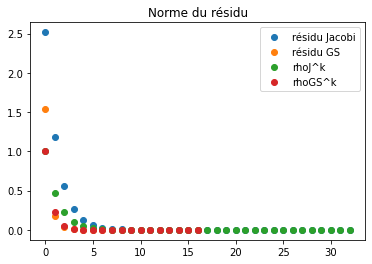

In [6]:
it_J = len(tab_err_J)#nombre d'iterations
it_GS = len(tab_err_GS)

rho_J = rhoJacobi(L, U, D)
powers_rho_J = np.empty(it_J)
for i in range(it_J):
    powers_rho_J[i] = rho_J**i

rho_GS = rhoGaussSeidel(L, U, D)
powers_rho_GS = np.empty(it_GS)
for i in range(it_GS):
    powers_rho_GS[i] = rho_GS**i

iterations_J = np.arange(0, it_J)#axe-x pour le graphique
iterations_GS = np.arange(0, it_GS)

plt.figure()
plt.title("Norme du résidu")
plt.scatter(iterations_J,  tab_err_J, label="résidu Jacobi")
plt.scatter(iterations_GS,  tab_err_GS, label="résidu GS")
plt.scatter(iterations_J, powers_rho_J, label="rhoJ^k")
plt.scatter(iterations_GS, powers_rho_GS, label="rhoGS^k")
plt.legend()
plt.show()

In [7]:
print(rhoJacobi(L, U, D))
print(rhoGaussSeidel(L, U, D))

0.4714045207910316
0.2222222222222222


**Réponse :** 

<div class="alert alert-block alert-info">
    Dans ce cas, on observe $\rho(B_{GS}) < \rho(B_J)$, donc, la convergence par Gauss-Seidel est plus rapide ce qu'on observe dans le graphique. $\rho(B_{GS})^k$ décroit plus rapidement et le nombre d'itérations pour Gauss-Seidel est plus petit (la courbe de GS est toujours au-dessous et s'arrète plus tôt).
</div>

## Exercice 3 : Méthode de gradient à pas fixe

>On considère ici $A\in M_n(\mathbb{R})$ symétrique définie positive et $b\in\mathbb{R}^n$. Afin de résoudre numériquement $Ax=b$, on va chercher à approcher le minimum de la fonction $f:\mathbb{R}^n\to \mathbb{R}$ définie par
>
>$$ f(x) = \frac{1}{2} \langle Ax,x\rangle - \langle b,x\rangle. $$
>
>Pour ce faire, on considère une méthode de gradient à pas fixe, c'est à dire une suite de la forme
>
>$$ \left\{ \begin{aligned} &x_0 \in \mathbb{R}^n\\ &x_{k+1} = x_k - \alpha \nabla f(x_k) \quad{} \forall~k\in\mathbb{N}. \end{aligned}\right.  \quad{} (4)$$

### Question 1 

Calculer $\nabla f(x)$ et vérifier que $f$ admet bien un unique minimum qui est atteint en $x^* = A^{-1}b$.

<div class="alert alert-block alert-info">
    $\nabla f(x) = Ax - b$ et $\nabla^2 f(x) = A \implies f(x)$ est strictement convexe. Donc, $f$ admet un unique minimum global là où $\nabla f(x) = 0$.
</div>

### Question 2 : Étude de convergence

On note $0 < \lambda_1 \le \dots \le \lambda_N$ les valeurs propres de $A$.

$1$. Montrer que la suite $(x_k)_{k\in\mathbb{N}}$ converge pour tout $x_0$ si et seulement si $0<\alpha<\frac{2}{\rho(A)}$.

<div class="alert alert-block alert-info">
    Soit $B = I - \alpha A$, on a $x_{k+1} = x_k - \alpha(Ax_k - b) = Bx_k + \alpha b$. $\\$
    Alors, la suite converge $\iff \rho(B) < 1 \iff |1 - \alpha \lambda_i| < 1 \quad \forall i$. $\\$
    On remarque que $\min_i \frac{2}{\lambda_i} = \frac{2}{\rho(A)}$. Donc $0 < \alpha < \frac{2}{\lambda_i} \quad \forall i \implies 0 < \alpha < \frac{2}{\rho(A)}$.
</div>

$2$. Déterminer la valeur de $\alpha$ qui maximise le taux de convergence en norme 2, et montrer qu'on a alors l'estimation d'erreur suivante :

$$\left\Vert x_k - x\right\Vert_2 \leq \left(\frac{\kappa_2(A)-1}{\kappa_2(A)+1}\right)^k \left\Vert x_0 - x\right\Vert_2.$$

<div class="alert alert-block alert-info">
    On veut trouver $\alpha$ qui minimise $\rho(B) = \max\{1 - \alpha \lambda_i\} \iff 1 - \alpha \lambda_1 = 1 - \alpha \lambda_n \iff \alpha = \frac{2}{\lambda_1 + \lambda_n}$. $\\$
    Pour cet $\alpha$, on a $\rho(B) = \frac{\lambda_n - \lambda_1}{\lambda_n + \lambda_1} = \frac{\frac{\lambda_n}{\lambda_1} - 1}{\frac{\lambda_n}{\lambda_1} + 1} = \frac{\kappa_2(A) - 1}{\kappa_2(A) + 1}$. $\\$
    Par la question 4 de l'exercice 1, on a
    $$\left\Vert x_k - x\right\Vert_2 \leq \rho(B)^k\left\Vert x_0 - x\right\Vert_2 = \left(\frac{\kappa_2(A)-1}{\kappa_2(A)+1}\right)^k \left\Vert x_0 - x\right\Vert_2.$$
</div>

### Question 3 : Implémentation

>En pratique, on utilise l’algorithme décrit en (4) avec deux critères d’arrêts : un nombre maximum d’itérations, et une tolérance sur l’erreur (par exemple $\|A x_k -b\| \le Tol$).

$1$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>** 

$a$. Implémenter une fonction qui prend en entrée une matrice $A$, un vecteur $b$, un pas $\alpha$, une donnée initiale $x_0$, un nombre d'itération maximum $N_{max}$ et un critère de tolérance $Tol$ et qui renvoie les itérés $x_k$ obtenus par la méthode du gradient à pas fixe, ainsi que l'erreur résiduelle $\Vert Ax_k -b\Vert$ à chaque itération.

> **Remarque sur la performance :** Là encore, stocker toutes les itérations a uniquement pour but d'étudier l'algorithme, mais consomme inutilement beaucoup d'espace mémoire.

$b$. Tester votre algorithme sur le système $2\times 2$ suivant :

$$
    A = \begin{pmatrix}
    1 & 0 \\
    0 & 7
    \end{pmatrix},\qquad{} b=\begin{pmatrix}
    2 \\ -1
    \end{pmatrix}. \quad{} (5)
$$

Tracer les lignes de niveaux de la fonction $f:x\mapsto \frac{1}{2} \langle Ax,x\rangle - \langle b,x\rangle$ associée dans le plan $(x_1,x_2)$, ainsi que les 10 premiers itérés obtenus. *Utiliser la fonction contour de matplotlib.pyplot.* Commenter les résultats obtenus pour $\alpha = 0.1$,  $\alpha = 0.25$ et $\alpha=0.3$. Pour le pas $\alpha$ optimal, vérifier également qu'on obtient bien la vitesse de convergence prévue. 

In [8]:
# Fonction f pour tracer ses lignes de niveau
def f(A, b, x1, x2):
    """
    Calcule f(x)=1/2*<Ax,x> - <b,x> dans le cas N=2, pour x=(x1,x2).
    Cette implementation permet d'avoir en argument des matrices contenant de nombreuses valeurs de x1 et x2 
    (compatible avec meshgrid)
    """
    return 1/2*((A[0,0]*x1+A[0,1]*x2)*x1 + (A[1,0]*x1+A[1,1]*x2)*x2) - b[0]*x1 - b[1]*x2

In [9]:
def gradient_pas_fixe(A, b, alpha, x0, it_max = 10**4, tol = 10**(-5)):
    """
    Calcule les itérés successifs x_k obtenus par la méthode du gradient à pas fixe
    ----------   
    parametres:
    A      : matrice symétrique de taille nxn 
    b      : vecteur de taille n (le second membre du système Ax=b qui nous intéresse)
    alpha  : un réel (le "pas")
    x_0    : vecteur de taille n (la donnée initiale)
    it_max : nombre maximal d'itérations
    tol    : on utilise || Ax_k - b || < tol comme critère d'arrêt 
    
    valeurs de retour:
    tab_x   : tableau contenant les itérations successives x_k obtenues
    tab_err : tableau contenant la norme du résidu || Ax_k - b || à chaque itération
    """ 
    xk = x0
    i = 0
    
    tab_err = np.empty(it_max)
    tab_x = np.empty((it_max,2))
    
    grad_f = np.matmul(A, x0) - b
    
    while(lin.norm(grad_f) > tol and i < it_max):
        xk = xk - alpha*grad_f
        
        grad_f = np.matmul(A, xk) - b
        tab_err[i] = lin.norm(grad_f)
        tab_x[i] = xk
        
        i += 1
        
    return tab_x[:i], tab_err[:i]

In [10]:
# grille pour tracer les lignes de niveau de la fonction f
nx1    = 1000
nx2    = 1000
x1     = np.linspace(-0.5, 2.5, nx1)
x2     = np.linspace(-1.5, 1.5, nx2)
x1, x2 = np.meshgrid(x1, x2)

A     = np.array([[1,0],[0,7]])
b     = np.array([2,-1])
x1_th = 2
x2_th = -1/7
z     = f(A, b, x1, x2)
x0    = np.ones(len(b)) 

alpha = 0.1
tab_x_1, tab_err_1 = gradient_pas_fixe(A, b, alpha, x0)

alpha = 0.25
tab_x_2, tab_err_2 = gradient_pas_fixe(A, b, alpha, x0)

alpha = 0.3
tab_x_3, tab_err_3 = gradient_pas_fixe(A, b, alpha, x0, 100)

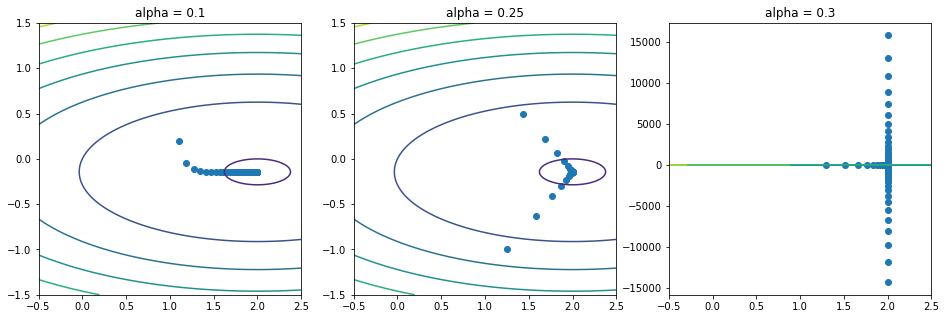

In [11]:
# Figure où les lignes de niveaux de f sont tracées
# Tracer les valeurs successives de xk
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.contour(x1, x2, z)
dim0, dim1 = np.hsplit(tab_x_1, 2)
plt.scatter(dim0, dim1)

plt.title('alpha = 0.1')

plt.subplot(1,3,2)
plt.contour(x1, x2, z)
dim0, dim1 = np.hsplit(tab_x_2, 2)
plt.scatter(dim0, dim1)

plt.title('alpha = 0.25')

plt.subplot(1,3,3)
plt.contour(x1, x2, z)
dim0, dim1 = np.hsplit(tab_x_3, 2)
plt.scatter(dim0, dim1)

plt.title('alpha = 0.3')

plt.show()

**Réponse :**

<div class="alert alert-block alert-info">
    Comme atendu, on remarque que la méthode converge bien pour $\alpha$ assez petit, mais à partir d'un certain valeur de $\alpha$ on observe des problèmes de convergence. Dans ce cas, pour $\alpha = 0,3$ on remarque que $(x_k)$ a explosé dans la coordonée $y$.
</div>

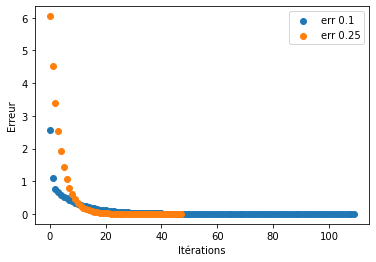

In [12]:
# Tracer l'erreur en fonction de l'itération
plt.figure()
it_1 = np.arange(0, len(tab_err_1))
plt.scatter(it_1, tab_err_1, label="err 0.1")
it_2 = np.arange(0, len(tab_err_2))
plt.scatter(it_2, tab_err_2, label="err 0.25")

plt.xlabel("Itérations")
plt.ylabel("Erreur")
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    On plotte $\alpha=0,1$ et $\alpha=0,25$ pour comparer les erreurs. On en conclue que $\alpha=0,25$ est le pas optimale. $\\$
    Pour le pas optimale $\alpha = 0,25$, on remarque que la vitesse de convergence est exponentielle, comme attendu pour la suite $$\left\Vert x_k - x\right\Vert_2 \leq \rho(B)^k\left\Vert x_0 - x\right\Vert_2 = \left(\frac{\kappa_2(A)-1}{\kappa_2(A)+1}\right)^k \left\Vert x_0 - x\right\Vert_2.$$
</div>

### Question 4 : Retour sur le Laplacien 1D

>On revient dans cette question sur le problème 
>
>$$
\left\{ 
\begin{aligned}
&-u''(x)   = x^3        \quad{} x  \in ]0,1[ \\ 
& u(0) = 0 = u(1)
\end{aligned}
\right. \quad{} (6)
$$
>
>et sur le problème discrétisé associé déjà étudié dans la PC précédente :
>
>$$
AU =F \quad{} \text{où}\quad{}  A = 
    \begin{pmatrix}
      2/h^2    & -1/h^2    & 0       &\dots   & 0 \\
      -1/h^2    & 2/h^2    & -1/h^2     & \ddots& \vdots  \\
      0      & \ddots & \ddots &\ddots  &0\\
      \vdots & \ddots & \ddots &\ddots  & -1/h^2\\
      0      & \dots  &  0   &   -1/h^2  & 2/h^2
    \end{pmatrix},
    \quad{} b = 
    \renewcommand{\arraystretch}{1.2}
    \begin{pmatrix}
      x_1^3 \\ x_2^3 \\ \vdots \\ x_{N-1}^3 \\ x_N^3
    \end{pmatrix}, \quad{} h=\frac{1}{N+1}, \qquad{} (7)
$$
>
>où les $x_i=ih$, $i=1,\ldots, N$, correspondent à une discrétisation du segment $[0,1]$, et les coordonnées $u_i$, de $U$ sont censées approcher les valeurs $u(x_i)$ de la solution de (6).
>
> **Remarque sur la performance :** Pour travailler sur la matrice du Laplacien, de taille plus grande, on va éviter de surcharger l'algorithme avec des calculs et du stockage non-nécessaire et revenir à une implémentation plus performante adaptée à la matrice du Laplacien. 

$1$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>** Reprogrammer l'algorithme du gradient à pas fixe comme précedemment, mais sans stocker toutes les itérations intermédiaires. On prendra garde à implementer les produits matrice/vecteur de manière compatible avec le stockage creux (utiliser *A.dot(x)* et pas *np.dot(A,x)*).

Utiliser maintenant l’algorithme du gradient à pas fixe pour approcher la solution du système (7), avec N = 63, en utilisant un pas $\alpha$ optimal obtenu à la question 2 (on pourra utiliser les fonctions de la librairie sparse pour cela) et avec $x_0 = (1,0,\dots,0)^T$, $N_{\max} = 10^3$ et $Tol = 10^{-5}$.  Afficher le nombre d'itérations effectuées, et l'erreur résiduelle $\|Ax^k-b\|$ obtenue à la dernière itération.

*On mettra à profit la structure creuse de $A$, et on construira donc $A$ à l'aide de la fonction scipy.sparse.diags. Afin de déterminer le pas optimal, on pourra utiliser les formules théoriques donnant les valeurs propres de $A$ vues en cours, ou calculer numériquement la plus petite et la plus grande valeur propre de $A$ à l'aide de la fonction scipy.sparse.linalg.eigs (renommé sparse_eigs en en-tête).*

In [13]:
def gradient_pas_fixe_creux(A, b, alpha, x0, it_max = 10**3, tol = 10**(-5)):
    """
    Calcule les itérés successifs x_k obtenus par la méthode du gradient à pas fixe
    ----------   
    parametres:
    A      : matrice symétrique de taille nxn 
    b      : vecteur de taille n (le second membre du système Ax=b qui nous intéresse)
    alpha  : un réel (le "pas")
    x_0    : vecteur de taille n (la donnée initiale)
    it_max : nombre maximal d'itérations
    tol    : on utilise || Ax_k - b || < tol comme critère d'arrêt 
    
    valeurs de retour:
    x       : le dernier itéré x_k obtenue
    tab_err : tableau contenant la norme du résidu || Ax_k - b || à chaque itération
    """
    xk = x0
    i = 0
    
    tab_err = np.empty(it_max)
    grad_f = A.dot(x0) - b
    
    while(lin.norm(grad_f) > tol and i < it_max):
        xk = xk - alpha*grad_f
        
        grad_f = A.dot(xk) - b
        tab_err[i] = lin.norm(grad_f)
        
        i += 1
    return xk, tab_err[:i]

In [14]:
#on utilisera des fonctions faites a la PC4 comme auxiliares
def moins_Laplacien_1D_tridiag(N):
    """
    crée la matrice 3xN correspondant à la discrétisation de -\Delta en 1D, en format tridiagonal
    ----------   
    parametre:
    N   : taille de la matrice
    
    valeur de retour:
    matrice de taille 3xN
    """
    C = np.zeros((3, N))
    h = 1.0/(N+1)
    for i in range(N):
        if(i > 0):
            C[0][i] = -1/(h*h) #bi
        C[1][i] = 2/(h*h)#ai
        if(i+1 < N):
            C[2][i] = -1/(h*h)#ci
    return C

def second_membre_1D(N):
    """
    crée le second membre de taille N en 1D, donne par f_i = f(x_i)
    ----------   
    parametre:
    N   : taille du vecteur
    
    valeur de retour:
    veteur de taille N
    """
    f = np.zeros(N)
    h = 1.0/(N+1)
    for i in range(N):
        xi = (i+1)*h
        f[i] = (xi**3)
    return f

In [15]:
# Cellule de test (on refait l'exercice précedent avec cette nouvelle méthode)
A = sparse.diags([[1,7]], [0], shape=(2,2)).toarray()
b = [2, -1]

u0 = [1, 1]
u, tab_err = gradient_pas_fixe_creux(A, b, 0.1, u0)

print(u)

[ 1.99999074 -0.14285714]


<div class="alert alert-block alert-info">
    Étant donné la tolerance établit, on remarque que le test est réussi.
</div>

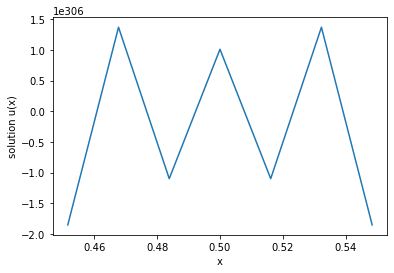

alpha optimale: 0.010580868560097037
nombre d'iterations: 139
erreur à la derniere iteration: nan


In [16]:
# Plot de la solution U du Laplacien en fonction de x
N            = 63

diags = moins_Laplacien_1D_tridiag(N) #on calcules les 3 diagonales a,b,c avec fonction de la pc4
b,a,c = np.vsplit(diags, 3)
b = np.delete(b, 0) #pour utiliser sparse.diags on supprime le 0 dans b
c = np.delete(c, N-1) #pour utiliser sparse.diags on supprime le 0 dans c
diags = [a,b,c]

C = sparse.diags(diags, [0, 1, -1], shape=(N,N)).toarray()
b = second_membre_1D(N) #on utilise fonction de la pc4 pour construir b

vals, vecs = sparse_eigs(C)
kappa = np.max(abs(vals))/np.min(abs(vals))#avec les eigenvalues, on calcule le conditionnement
alpha_opt = (kappa - 1)/(kappa + 1)

u0 = np.ones(N)
u, tab_err = gradient_pas_fixe_creux(C, b, alpha_opt, u0)

x = np.linspace(0, 1, N)

plt.figure()
plt.plot(x, u)
plt.xlabel("x")
plt.ylabel("solution u(x)")
plt.show()

print(f"alpha optimale: {alpha_opt}")
print(f"nombre d'iterations: {len(tab_err)}")
print(f"erreur à la derniere iteration: {tab_err[-1]}")

$2$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>** Etudier numériquement le taux de convergence obtenu. Tracer l'erreur $\|Ax^k-b\|$ en fonction de $k$ en échelle semilog. Comparer avec la majoration théorique.

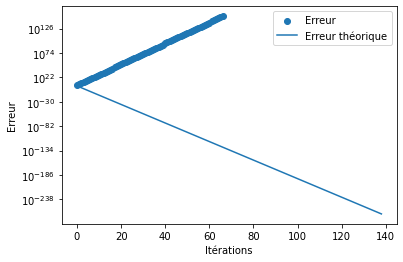

In [17]:
# Tracer l'erreur en fonction du nombre d'itérations
plt.figure()

it_cnt = np.arange(0, len(tab_err))
plt.scatter(it_cnt, tab_err, label="Erreur")

e0 = lin.norm(C.dot(u0) - b)
err_theorique = np.zeros(len(tab_err))
for i in range(len(tab_err)):
    err_theorique[i] = (alpha_opt**i)*e0
plt.plot(it_cnt, err_theorique , label="Erreur théorique")

plt.yscale("log") #echelle log pour l'axe y
plt.xlabel("Itérations")
plt.ylabel("Erreur")
plt.legend()
plt.show()

**Réponse :** 

$3$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>** Afficher la solution discrète $u_i$ obtenue après $10^3$ itérations, ainsi que la solution théorique. Commenter.

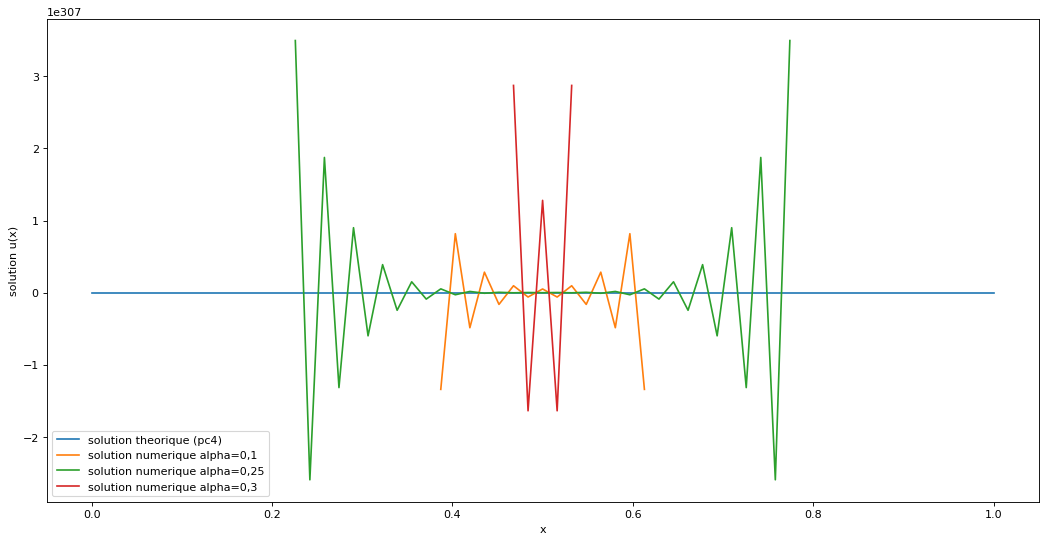

Solutions numériques (0.1, 0.25, 0.3) : [            -inf              inf             -inf              inf
             -inf              inf             -inf              inf
             -inf              inf             -inf              inf
             -inf              inf             -inf              inf
             -inf              inf             -inf              inf
             -inf              inf             -inf              inf
 -1.34212178e+307  8.17566058e+306 -4.86821888e+306  2.83948466e+306
 -1.63466209e+306  9.53746382e+305 -6.11315800e+305  5.07614862e+305
 -6.11296242e+305  9.53700205e+305 -1.63457342e+306  2.83932506e+306
 -4.86794135e+306  8.17519067e+306 -1.34204415e+307              inf
             -inf              inf             -inf              inf
             -inf              inf             -inf              inf
             -inf              inf             -inf              inf
             -inf              inf             -inf            

In [18]:
C_banded = moins_Laplacien_1D_tridiag(N)
sol_banded = solve_banded((1,1), C_banded, b)

u1, tab_err1 = gradient_pas_fixe_creux(C, b, 0.1, u0, 1000)
u2, tab_err2 = gradient_pas_fixe_creux(C, b, 0.25, u0, 1000)
u3, tab_err3 = gradient_pas_fixe_creux(C, b, 0.3, u0, 1000)

x = np.linspace(0, 1, N)
 
plt.figure(figsize=(16, 8), dpi=80)
plt.plot(x, sol_banded, label='solution theorique (pc4)')
plt.plot(x, u1, label='solution numerique alpha=0,1')
plt.plot(x, u2, label='solution numerique alpha=0,25')
plt.plot(x, u3, label='solution numerique alpha=0,3')
plt.xlabel("x")
plt.ylabel("solution u(x)")
plt.legend()
plt.show()

print("Solutions numériques (0.1, 0.25, 0.3) :", u1, u2, u3) 
print("Solution théorique :", sol_banded) 

**Réponse :**

<div class="alert alert-block alert-info">
    On remarque que pour cette problème même si théoriquement la méthode converge, en pratique on rencontre des problèmes de précision qui font la solution exploser. Il s'agit des problèmes de précision machine, une fois qu'on a calcule $\kappa(A)$ et le problème est bien conditionné.
</div>

## Exercice 4 : Méthode du gradient conjugué (GC)
  
>Soit $A$ une matrice réelle de taille $n \times n$, symétrique définie positive. Une telle matrice peut définir un produit scalaire donné par 
>
>$$ \langle x,y \rangle_A = x^TAy.$$
>
>  Deux vecteurs $d_1$ et $d_2$ sont dits conjugués par rapport à $A$ s'ils sont orthogonaux par rapport au produit scalaire $\langle \cdot,\cdot \rangle_A$. Dans la suite on notera la norme associée par $\|\cdot \|_A=\sqrt{\langle \cdot,\cdot \rangle_A}$.
>
>On décrit ci-dessous l'algorithme du gradient conjugué :
>
>**Initialisation :** On donne $A\in \Bbb{R}^{n\times n}$ matrice réelle, symétrique, définie positive, $b\in \Bbb{R}^n$, $x_0 \in \mathbb{R}^n$ et une tolérance $Tol$.
>- $i=0$.
>- Calculer le premier résidu $g_0 = (Ax_0-b)$ et la première direction de descente $d_0 = -g_0$.
>- Tant que $\Vert g_i\Vert  > Tol$ et $i<n$
>    - Calculer la nouvelle itération $$ x_{i+1} = x_i-\gamma_i d_i \quad{}\text{avec}\quad{} \gamma_i = \frac{d_i^Tg_i}{d_i^TAd_i} = \frac{\langle d_i,g_i\rangle}{\langle d_i,d_i\rangle_A}.$$
>    - Calculer le nouveau résidu $g_{i+1} = Ax_{i+1}-b.$
>    - Calculer la nouvelle direction de descente $$ d_{i+1} = -g_{i+1}+\beta_id_i \quad{}\text{avec}\quad{} \displaystyle \beta_i = \frac{g_{i+1}^TAd_i}{d_i^TAd_i} = \frac{\langle g_{i+1},d_i\rangle_A}{\langle d_i,d_i\rangle_A}.$$
>
>On peut montrer que cet algorithme conduit l'estimation d'erreur suivante, qui est meilleure que celle obtenue pour le gradient à pas fixe :
>
>$$\left\Vert x_k - x\right\Vert_A \leq 2\left(\frac{\sqrt{\kappa_2(A)}-1}{\sqrt{\kappa_2(A)}+1}\right)^k \left\Vert x_0 - x\right\Vert_A.$$
>
>Qui plus est, on peut également montrer (voir la Question 4 ce det exercice) que l'algorithme du GC converge en fait en au plus n itérations! Autrement dit, l'erreur est souvent plus faible que celle donnée par l'estimation ci-dessus. En pratique, on n'effectue quasiment jamais les n itérations du GC, mais on s'arrête dès que l'erreur résiduelle passe sous un seuil donné.

### Question 1 : Implémentation

$1$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>** Montrer que dans l'algorithme du GC décrit ci-dessus, $g_{i+1} = g_i - \gamma_i Ad_i$. Quel est le nombre minimal de multiplications matrice/vecteur nécessaire pour effectuer une itération du GC? Quel(s) produit(s) doit on stocker? 

$2$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>** Implémenter l'algorithme du gradient conjugué. *On effectuera le moins de multiplications matrice/vecteur possible.*

>**Remarque sur la performance :** Dans un premier temps, on stockera toutes les itérations $x^k$ pour étudier la méthode.

$3$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>** Tester votre algorithme sur le système $2\times 2$ donné en (5). Tracer à nouveau les lignes de niveaux de la fonction $f$ associée, ainsi que les différents itérés obtenus. Comparer avec le gradient à pas fixe et commenter les différents comportements.

**Réponse :** 1)
On a $g_{i+1} = Ax_{i+1} - b = A(x_i - \gamma_i d_i) - b = (Ax_i - b) - \gamma_i A d_i = g_i - \gamma_i A d_i$. $\\$
Si on stocke $Ad_i$ et $d_i^T Ad_i$, on fait $4$ multiplications matrice/vecteur par itération.


In [19]:
def gradient_conjugué(A, b, x0, it_max = 10**3, tol = 10**-5):
    """
    Calcule les itérés successifs x_k obtenus par la méthode du gradient conjugué
    ----------   
    parametres:
    A      : matrice symétrique de taille nxn 
    b      : vecteur de taille n (le second membre du système Ax=b qui nous intéresse)
    x_0    : vecteur de taille n (la donnée initiale)
    it_max : un entier qui fixe le nombre maximal d'itérations
    tol    : on utilise || Ax_k - b || < tol comme critère d'arrêt 
    
    valeurs de retour:
    tab_x   : un tableau qui contient les itérations successives x_k obtenues
    tab_err : tableau contenant la norme du résidu || Ax_k - b || à chaque itération
    """
    i = 0
    gi = np.matmul(A, x0) - b
    di = -gi
    xi = x0
    
    tab_x = np.empty((it_max, len(x0)))
    tab_err = np.empty(it_max)
    
    while(lin.norm(gi) > tol and i < it_max):
        stock1 = np.matmul(A, di) #on stocke pour optimiser nombre de multiplications
        stock2 = np.matmul(np.transpose(di), stock1)
        
        gamma = np.matmul(np.transpose(di), gi)/stock2
        xi = xi - gamma*di
        tab_x[i] = xi
        
        gi = np.matmul(A, xi) - b
        tab_err[i] = lin.norm(gi)
        
        beta = np.matmul(np.transpose(gi), stock1)/stock2
        di = -gi + beta*di
        
        i+=1
    
    return tab_x[:i], tab_err[:i]

In [20]:
# 2)
# grille pour tracer les lignes de niveau de la fonction f
nx1    = 1000
nx2    = 1000
x1     = np.linspace(-0.5, 2.5, nx1)
x2     = np.linspace(-1.5, 1.5, nx2)
x1, x2 = np.meshgrid(x1, x2)

A     = np.array([[1,0],[0,7]])
b     = np.array([2,-1])
x1_th = 2
x2_th = -1/7
z     = f(A, b, x1, x2)
x0    = np.ones(len(b)) 


tab_x_GC, tab_err_GC = gradient_conjugué(A, b, x0)


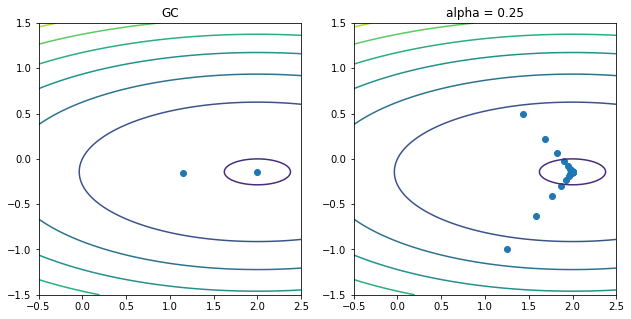

In [21]:
# Figure où les lignes de niveaux de f sont tracées
# Tracer les valeurs successives de xk
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.contour(x1, x2, z)
dim0, dim1 = np.hsplit(tab_x_GC, 2)
plt.scatter(dim0 , dim1)

plt.title('GC')

plt.subplot(1,3,2)
plt.contour(x1, x2, z)
tab_x_PF, tab_err_PF = gradient_pas_fixe(A, b, 0.25, [1,1])
dim0, dim1 = np.hsplit(tab_x_PF, 2)
plt.scatter(dim0 , dim1)

plt.title(f'alpha = {0.25}')

plt.show()

<div class="alert alert-block alert-info">
    On remarque que la convergence pour la nouvelle méthode est plus rapide, graphiquement elle semble presque immediate.
</div>

In [22]:
print(f"Taux de convergence à pas fixe {alpha_opt}")
taux_convergence = (np.sqrt(kappa)-1)/(np.sqrt(kappa)+1)
print(f"Taux de convergence GC: {taux_convergence}")

Taux de convergence à pas fixe 0.010580868560097037
Taux de convergence GC: 0.005290582360688636


### Question 2 : Retour sur le Laplacien 1D

**<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>** Reprogrammer l'algorithme du gradient conjugué comme précedemment, mais sans stocker toutes les itérations intermédiaires. On prendra garde à implementer les produits matrice/vecteur de manière compatible avec le stockage creux (utiliser *A.dot(x)* et pas *np.dot(A,x)*).

Utiliser cet algorithme pour obtenir une solution approchée du problème (7). Vérifier qu'on a bien convergence en au plus $N$ itérations, et afficher la solution obtenue. Pour ce problème, l'algorithme du gradient conjugué peut-il être intéressant par rapport aux méthodes directes basées sur la décomposition LU étudiées dans la PC précédente?

In [23]:
def gradient_conjugué_creux(A, b, x0, it_max = 10**3, tol = 10**-10):
    """
    Calcule les itérés successifs x_k obtenus par la méthode du gradient conjugué
    ----------   
    parametres:
    A  : matrice symétrique de taille nxn 
    b : vecteur de taille n (le second membre du système Ax=b qui nous intéresse)
    x_0 : vecteur de taille n (la donnée initiale)
    it_max : un entier qui fixe le nombre maximal d'itérations
    tol : on utilise || Ax_k - b || < tol comme critère d'arrêt 
    
    valeurs de retour:
    x : le dernier itéré x_k obtenu
    tab_err : tableau contenant la norme du résidu || Ax_k - b || à chaque itération
    """    
    i = 0
    gi = A.dot(x0) - b
    di = -gi
    xi = x0
    
    tab_x = np.empty((it_max, len(x0)))
    tab_err = np.empty(it_max)
    
    while(lin.norm(gi) > tol and i < it_max):
        stock1 = A.dot(di) #optimisation (cas creux)
        stock2 = np.matmul(np.transpose(di), stock1)
        
        gamma = np.matmul(np.transpose(di), gi)/stock2
        xi = xi - gamma*di
        
        gi = A.dot(xi) - b #optimisation (cas creux)
        tab_err[i] = lin.norm(gi)
        
        beta = np.matmul(np.transpose(gi), stock1)/stock2
        di = -gi + beta*di
        
        i+=1
        
    return xi, tab_err[:i]

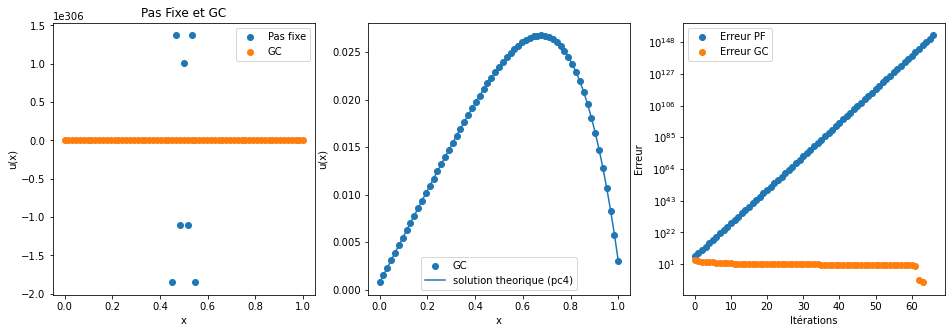

In [26]:
N            = 63

x0           = np.zeros(N)
x0[0] = 1.
b = second_membre_1D(N)


plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
x = np.linspace(0, 1, N)
u_PF, tab_err_PF = gradient_pas_fixe_creux(C, b, alpha_opt, x0)
plt.scatter(x, u, label="Pas fixe")

u_GC, tab_err_GC = gradient_conjugué_creux(C, b, x0)
plt.scatter(x, u_GC, label="GC")

plt.title("Pas Fixe et GC")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()

plt.subplot(1,3,2)
plt.scatter(x, u_GC, label="GC")
plt.plot(x, sol_banded, label='solution theorique (pc4)')

plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()

plt.subplot(1,3,3)
it_PF = np.arange(0, len(tab_err_PF))
plt.scatter(it_PF, tab_err_PF, label="Erreur PF")
it_GC = np.arange(0, len(tab_err_GC))
plt.scatter(it_GC, tab_err_GC, label="Erreur GC")
plt.yscale("log") #echelle log pour l'axe y
plt.xlabel("Itérations")
plt.ylabel("Erreur")
plt.legend()
plt.show()

plt.show()

**Réponse :** 

In [27]:
%timeit solve_banded((1,1), C_banded, b) #methode de la PC4
%timeit gradient_conjugué_creux(C, b, x0) #algorithme GC

21 µs ± 386 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
2.1 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<div class="alert alert-block alert-info">
    Premièrement, il faut remarquer que l'algorithme du gradient conjugué a réussi à obtenir des erreurs beaucoup plus petits que  l'algorithme du gradient à pas fixe. Graphiquement, on observe que la courbe est très proche de la solution obtenue à la PC4.
    Par contre, si on analyse le temps d'éxecution, on conclue que la méthode employé à la PC4 est encore la plus performante pour ce problème.
</div>

### Question 3 : Retour sur le Laplacien 2D

>On étudie dans cette question sur le problème 
>
>$$
\left\{ 
\begin{aligned}
&-\Delta u(x,y) = 1       \quad{} (x,y)  \in ]0,1[^2 \\ 
& u(0,y) = 0 = u(1,y) = u(x,0) = u(x,1)
\end{aligned}
\right. \quad{} (8)
$$
>
>et sur le problème discrétisé associé déjà étudié dans la PC précédente :
>
>$$
AU =F \quad{} \text{où}\quad{}  A = 
\left( \begin{array}{c|c|c|c|c}
      D    & -I/h^2    &0 &\dots   & 0 \\ \hline
      -I/h^2    & D    & \ddots&  \ddots &\vdots  \\ \hline
      0    &  \ddots   & \ddots & \ddots& 0  \\ \hline
      \vdots   & \ddots &\ddots & \ddots &-I/h^2\\ \hline
      0      & \dots & 0 &   -I/h^2  & D
    \end{array}\right), \quad{}
    D = \left( \begin{array}{ccccc}
      4/h^2    & -1/h^2  & 0  & \dots   & 0 \\
      -1/h^2    & 4/h^2    & \ddots& \ddots& \vdots  \\   
      0      & \ddots & \ddots & \ddots  & 0\\
      \vdots & \ddots & \ddots  & \ddots & -1/h^2\\
      0      & \dots  & 0 & -1/h^2  & 4/h^2
    \end{array}\right) \in\mathbb{R}^{N},
    \qquad{} 
    \quad{} F = 
    \renewcommand{\arraystretch}{1.2}
    \begin{pmatrix}
      1 \\ 1 \\ \vdots \\ 1 \\ 1
    \end{pmatrix}, \quad{} h=\frac{1}{N+1}, \qquad{} (9)
$$
>
>où les $(x_i,y_j)=(ih,jh)$, $i,j=1,\ldots, N$, correspondent à une discrétisation du carré $[0,1]^2$, et les coordonnées de $U$ sont censées approcher les valeurs $u(x_i,y_j)$ de la solution de (8).

$1$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>** Construire la matrice du Laplacien 2D discrétisé, dans un format creux. On pourra utiliser *scipy.sparse.diags*.

In [30]:
def moins_Laplacien_2D_bande(N):
    """
    crée la matrice correspondant à la discrétisation de -\Delta en 2D sous format bande
    ----------   
    parametre:
    N   : taille de la matrice
    
    valeur de retour:
    matrice de taille N^2xN^2 sous format bande
    """ 
    h = 1.0/(N+1)
    D = np.zeros((N,N)) #dabord, on construit D
    for i in range(N):
        D[i][i] = 4/(h*h)
        if(i > 0):
            D[i][i-1] = -1/(h*h)
        if(i + 1 < N):
            D[i][i+1] = -1/(h*h)
    Isq = np.zeros((N,N)) #alors, on construit -I/h**2
    for i in range(N):
        Isq[i] = -1/(h*h)
    Nsq = N*N
    C = np.zeros((Nsq, Nsq)) #on est pret pour construir C
    for i in range(N):
        if(i > 0):
            com_x1 = N*(i-1)
            com_y1 = N*i
            com_x2 = N*i
            com_y2 = N*(i-1)
            for j in range(N):
                for k in range(N):
                    C[com_x1 + j][com_y1 + k] = Isq[j][k] #gauche de la diagonale principale
                    C[com_x2 + j][com_y2 + k] = Isq[j][k] #en dessus de la diagonale principale
        com_x = N*i #on remplit la diagonale principale
        com_y = N*i
        for j in range(N):
            for k in range(N):
                C[com_x + j][com_y + k] = D[j][k]
    return C

In [34]:
# Cellule de test 
N = 3

print("Laplacien 2D :\n", moins_Laplacien_2D_bande(N))

Laplacien 2D :
 [[ 64. -16.   0. -16. -16. -16.   0.   0.   0.]
 [-16.  64. -16. -16. -16. -16.   0.   0.   0.]
 [  0. -16.  64. -16. -16. -16.   0.   0.   0.]
 [-16. -16. -16.  64. -16.   0. -16. -16. -16.]
 [-16. -16. -16. -16.  64. -16. -16. -16. -16.]
 [-16. -16. -16.   0. -16.  64. -16. -16. -16.]
 [  0.   0.   0. -16. -16. -16.  64. -16.   0.]
 [  0.   0.   0. -16. -16. -16. -16.  64. -16.]
 [  0.   0.   0. -16. -16. -16.   0. -16.  64.]]


$2$. **<font color=black><span style="background-color:deepskyblue">Bonus :</span></font>** Utiliser l'algortithme du GC pour obtenir une solution approchée du système (9). Afficher la solution obtenue à l'aide du code ci-dessous. Pour ce problème, l'algorithme du gradient conjugué peut-il être intéressant par rapport aux méthodes directes basées sur la décomposition LU étudiées dans la PC précédente?

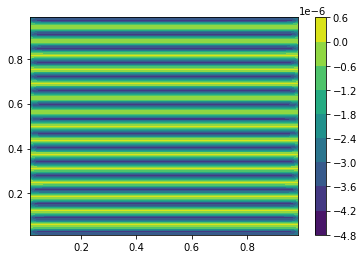

In [36]:
N = 63

A = moins_Laplacien_2D_bande(N)
b = np.ones(N*N)

# grille pour tracer la solution
nx     = N
ny     = N
dx     = 1./(nx+1)
dy     = 1./(ny+1)
x      = np.linspace(1,nx,nx)*dx
y      = np.linspace(1,ny,ny)*dy
xx, yy = np.meshgrid(x, y, indexing='xy')


# Solution
x0               = np.zeros(nx*ny)
x0[0] = 1.
U_GC, tab_err_GC = gradient_conjugué_creux(A, b, x0, it_max = 10**3, tol = 10**(-5))
Uij              = np.reshape(U_GC, (nx,ny))

# plot
plt.figure()
plt.contourf(xx,yy,np.reshape(U_GC,(nx,ny)))
plt.colorbar()
plt.show()

### Question 4 : Etude théorique

Dans cette question, on étudie les propriétés de l'algorithme du gradient conjugué décrit en début d'exercice.

$1$. En considérant $x$ la solution du système $Ax=b$, montrez que $\gamma_i$ minimise

$$\gamma \mapsto \|x_i-\gamma d_i -x^*\|_A^2.$$

$2$. Montrer que $\beta_i$ est défini de telle sorte que $\langle d_{i+1},d_i\rangle_A = 0$, i.e. tel que une direction $d_i$ soit A-orthogonale à la suivante $d_{i+1}$.     

$3$. Montrer les égalités suivantes

$$\langle g_{i+1}, d_i\rangle = 0, \qquad
  \langle d_i, d_i\rangle_A = -\langle d_i, g_i\rangle_A. $$

En déduire que $\langle g_{i+1},g_i\rangle = 0$, i.e. que le gradient $g_i$ est orthogonal au suivant $g_{i+1}$.



$4$. Montrer que  

$$\langle g_{i+1},g_j\rangle=0  \quad{} \text{ et } \quad{} \langle d_{i+1},d_j\rangle_A = 0 \quad \forall j = 0,...,i.$$

Conclure que l'algorithme du gradient conjugué converge en au plus $n$ itérations.

$5$. On admet que

$$\left\Vert x_k - x\right\Vert_A = \min_{\substack{P \in \mathbb{R}_k[X] \\ P(0)=1}} \left\Vert P(A)(x_0 - x)\right\Vert_A.$$

En déduire que, si le polynôme annulateur de $A$ est de degré $m$, alors l'algorithme du gradient conjugué converge en au plus $m$ itérations.